# Testing the embedding processsing methods
find_similar_qdrant, find_representative, leverage_OOD, find_mismatches

In [1]:
import numpy as np

from luxonis_ml.embeddings.utils.qdrant import *

from luxonis_ml.embeddings.methods.mistakes import find_mismatches_centroids
from luxonis_ml.embeddings.methods.OOD import leverage_OOD
from luxonis_ml.embeddings.methods.representative import (
    calculate_similarity_matrix,
    find_representative_kmedoids,
)
from luxonis_ml.embeddings.methods.duplicate import find_similar_qdrant

import matplotlib.pyplot as plt
import cv2

/home/paperspace/Luxonis/lux-ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Start Qdrant docker container
QdrantManager("qdrant/qdrant", "qdrant_container2").start_docker_qdrant()

# Connect to Qdrant
qdrant_api = QdrantAPI("localhost", 6333, "mnist3")

# Create a collection
qdrant_api.create_collection(vector_size=2048, distance=Distance.COSINE)

Container is already running.
Collection already exists


### Find representative images

In [3]:
ids = qdrant_api.get_all_ids()

In [4]:
# ids, embs, res = qdrant_api.get_full_similarity_matrix()

In [5]:
ids, embeddings = qdrant_api.get_all_embeddings()

In [6]:
similarity_matrix = calculate_similarity_matrix(embeddings)

In [7]:
desired_size = int(len(embeddings) * 0.05)
# desired_size = 10
selected_image_indices = find_representative_kmedoids(similarity_matrix, desired_size)
# selected_image_indices = find_representative_greedy_qdrant(qdrant_client, desired_size, 0, "mnist3")

In [8]:
ids_sel = np.array(ids)[selected_image_indices].tolist()
payloads = qdrant_api.get_payloads_from_ids(ids_sel)

In [9]:
represent_imgs = [p["image_path"] for p in payloads]
len(represent_imgs)

320

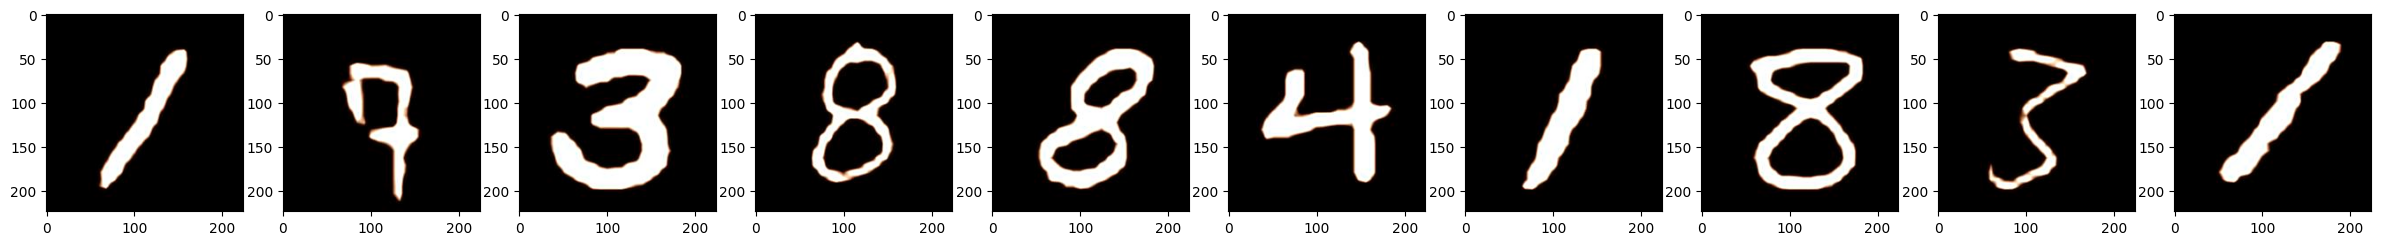

In [10]:
# set plt size
plt.rcParams["figure.figsize"] = [30, 10]

for j in range(min(10, len(represent_imgs))):
    plt.subplot(1, 10, j + 1)
    img = cv2.imread(represent_imgs[j])
    plt.imshow(img)

plt.show()

### Out-of-distribution detection

In [11]:
idx = leverage_OOD(np.array(embeddings))

In [12]:
ids_sel = np.array(ids)[idx].tolist()
payloads = qdrant_api.get_payloads_from_ids(ids_sel)

In [13]:
outlier_imgs = [p["image_path"] for p in payloads]

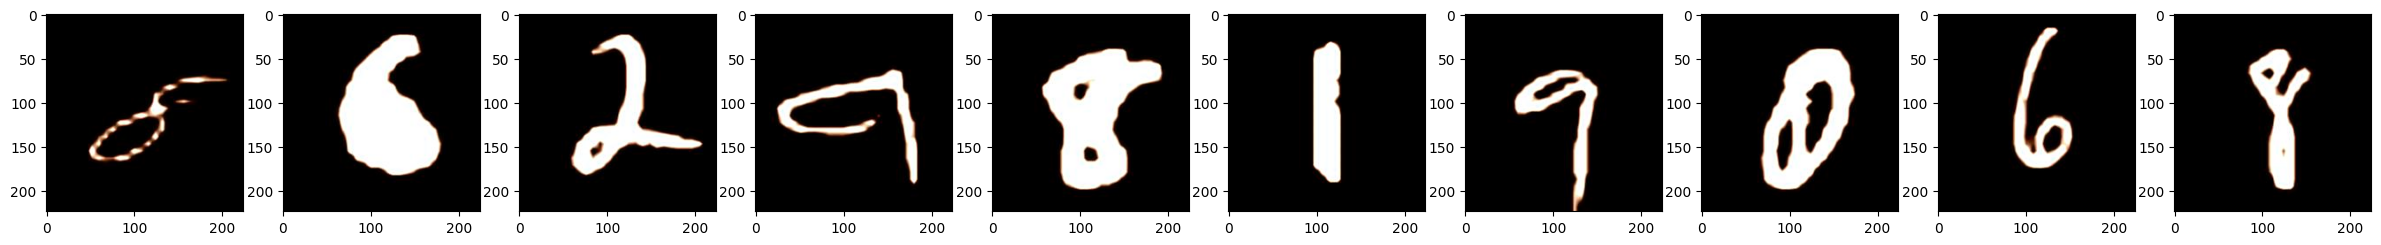

In [14]:
plt.rcParams["figure.figsize"] = [30, 10]

for j in range(min(10, len(outlier_imgs))):
    plt.subplot(1, 10, j + 1)
    img = cv2.imread(outlier_imgs[j])
    plt.imshow(img)

plt.show()

### Find similar images

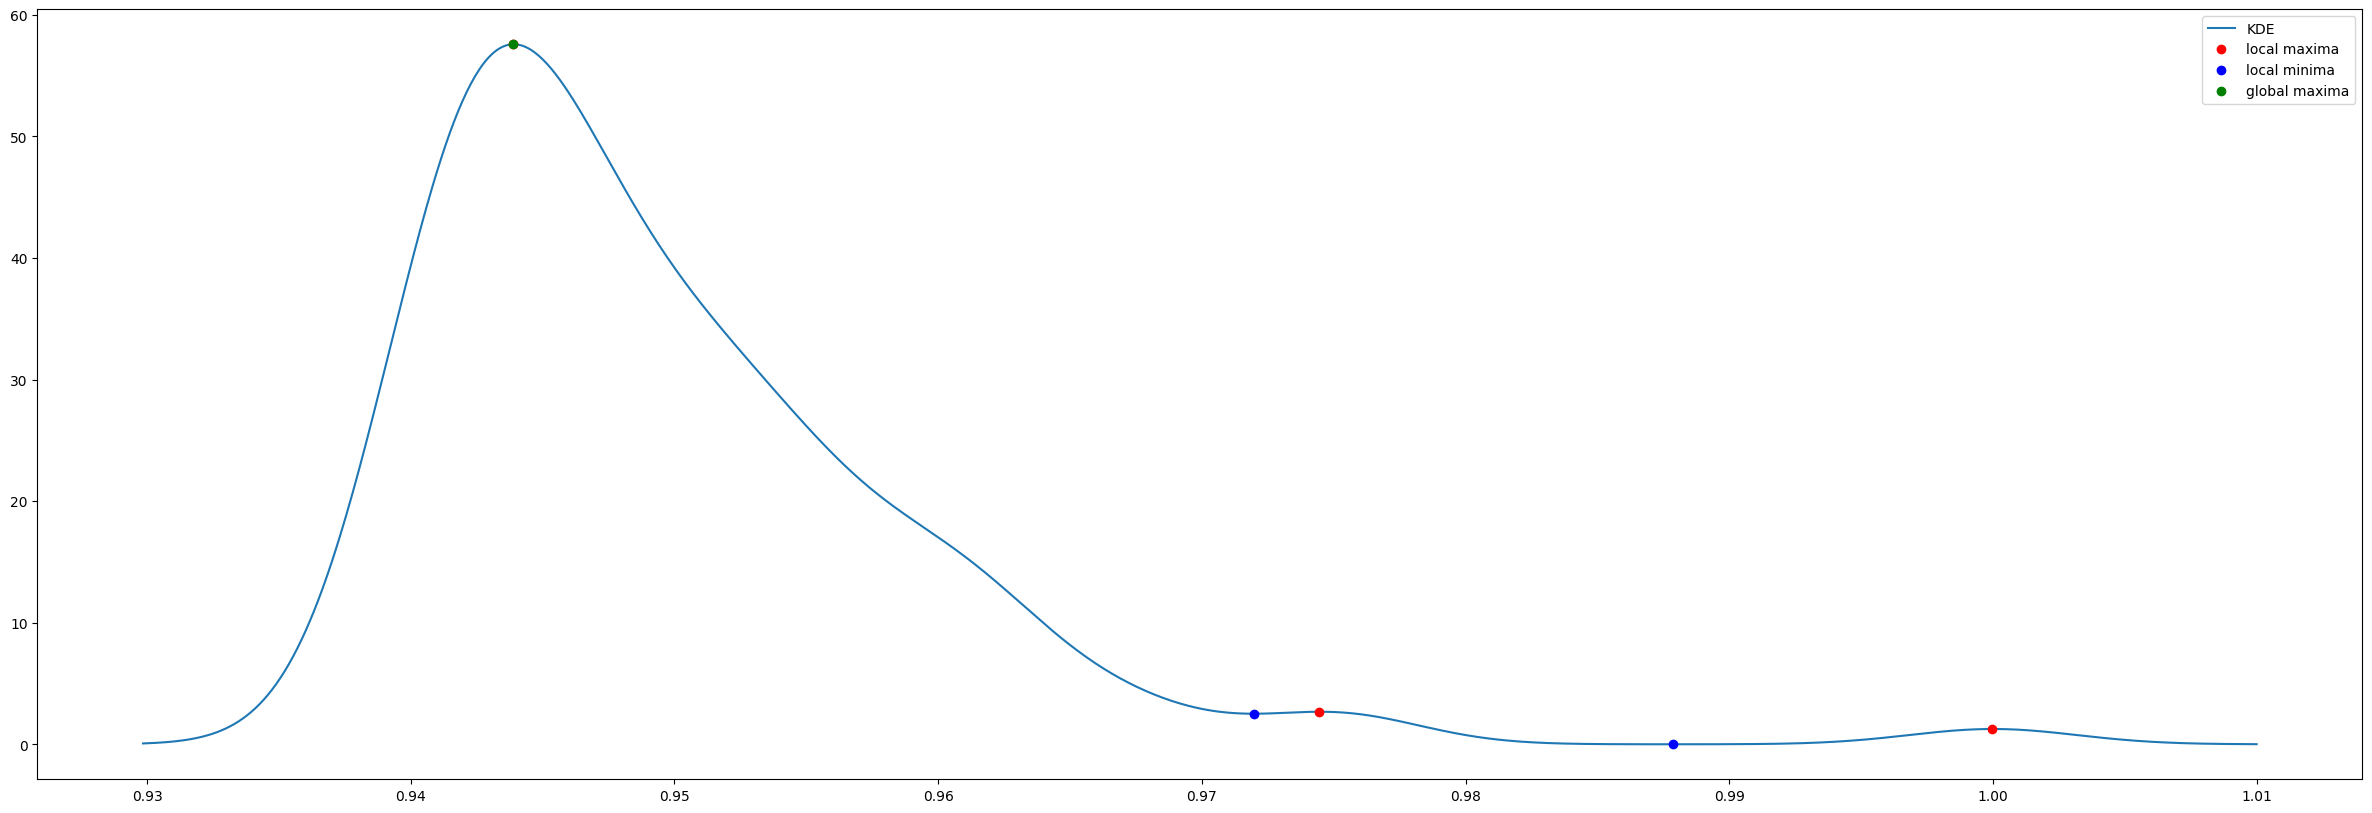

3 0.9878554618618619


In [15]:
i_sim, path_sim = find_similar_qdrant(
    ids[4],
    qdrant_api,
    dataset="",
    k=100,
    n=100,
    method="first",
    k_method="kde_peaks",
    kde_bw="scott",
    plot=True,
)

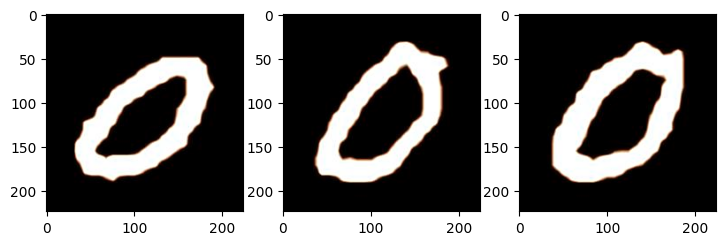

In [16]:
plt.rcParams["figure.figsize"] = [30, 10]

for j in range(min(10, len(path_sim))):
    plt.subplot(1, 10, j + 1)
    img = cv2.imread(path_sim[j])
    plt.imshow(img)

plt.show()

### Find mismatches

In [17]:
ids, embeddings = qdrant_api.get_all_embeddings()
payloads = qdrant_api.get_payloads_from_ids(ids)

In [18]:
X = np.array(embeddings)
y = np.array([p["class"] for p in payloads])

In [19]:
mis_ix, new_y = find_mismatches_centroids(X, y)

In [20]:
# find img paths for misclassified images
mis_img_paths = [payloads[i]["image_path"] for i in mis_ix]

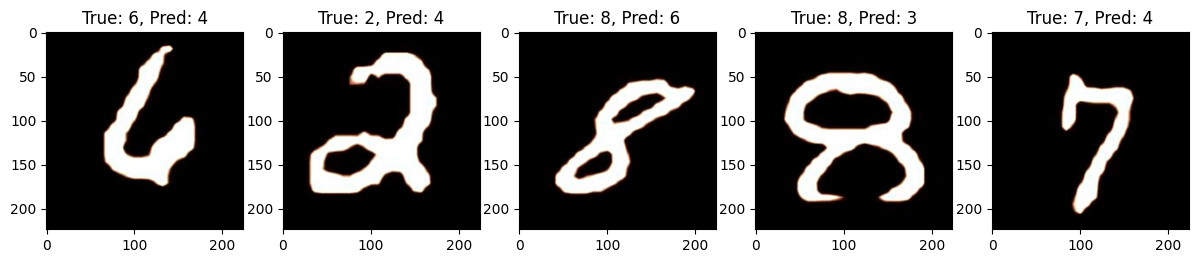

In [21]:
# plot
plt.rcParams["figure.figsize"] = [30, 10]

for j in range(min(5, len(mis_img_paths))):
    plt.subplot(1, 10, j + 1)
    img = cv2.imread(mis_img_paths[j])
    plt.title(f"True: {y[mis_ix[j]]}, Pred: {new_y[j]}")
    plt.imshow(img)

plt.show()